#**Importing Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd

import os
import librosa

import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import butter, lfilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

#**Filtering the Audio File**

In [2]:

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=3)

def FilterAudioFiles(record_path,output_path,lowcut,highcut,FRAME_RATE):
    for file in os.listdir(output_path):
        os.remove(os.path.join(output_path,file))

    WAV_FILE_NAME = os.listdir(record_path)
    

    for fileName in WAV_FILE_NAME:
        samplerate, data = wavfile.read(os.path.join(record_path, fileName))
        assert samplerate == FRAME_RATE
        filtered = np.apply_along_axis(bandpass_filter, 0, data)
        wavfile.write(os.path.join(output_path, fileName), samplerate, filtered.astype(np.int32))


  


**Filtering the test Files**

In [3]:
def filterTestFiles(test_record_path,test_output_path,FRAME_RATE = 16000,dataType = 'int32'):
    
    for file in os.listdir(test_output_path):
        os.remove(os.path.join(test_output_path,file))

    WAV_FILE_NAME = sorted(os.listdir(test_record_path), key=len)


    #print(WAV_FILE_NAME)

    

    for fileName in WAV_FILE_NAME:
        samplerate, data = wavfile.read(os.path.join(test_record_path, fileName))
        assert samplerate == FRAME_RATE
        filtered = np.apply_along_axis(bandpass_filter, 0, data)
        wavfile.write(os.path.join(test_output_path, fileName), samplerate, filtered.astype(dataType))


**Feature Extraction**

In [4]:
audio_train_files_dir = 'input/filteredTrainingData/'
train_csv = '/input/augmented_files_numbers.csv'

In [5]:

def get_mfccV2(name, path,SAMPLE_RATE = 16000):
    data, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft7 = librosa.feature.spectral_flatness(data)[0]
        #S, phase = librosa.magphase(librosa.stft(data))
        #ft8 = librosa.feature.rms(S=S)[0]
        #hop_length = 512
        #oenv = librosa.onset.onset_strength(y=data, sr=SAMPLE_RATE, hop_length=hop_length)
        #ft9 = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=SAMPLE_RATE,
                                              #hop_length=hop_length)

       
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1))) #180 features
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6))) 
        ft7_trunc = np.hstack((np.mean(ft7), np.std(ft7), skew(ft7), np.max(ft7), np.median(ft7), np.max(ft7))) #30 features. 
        #ft8_trunc = np.hstack((np.mean(ft8), np.std(ft8), skew(ft8), np.max(ft8), np.median(ft8), np.max(ft8)))
        #ft9_trunc = np.hstack((np.mean(ft9), np.std(ft9), skew(ft9), np.max(ft9), np.median(ft9), np.max(ft9)))
      #  ft7_trunc =  np.hstack((np.mean(ft7), np.std(ft7), skew(ft7), np.max(ft7), np.median(ft7), np.max(ft7)))
        return pd.Series(np.hstack((ft1_trunc ,ft2_trunc,ft3_trunc,ft4_trunc, ft5_trunc,ft6_trunc,ft7_trunc)))
    except:
        print('bad file')
        print('file = ',name)
        return pd.Series([0]*210)
    

In [6]:
def getFeaturesAndTrainPCA(audio_train_files_dir,train_csv):
    audio_train_files = os.listdir(audio_train_files_dir)
    train = pd.read_csv(train_csv)
    train_data = pd.DataFrame()
    train_data['fname'] = train['fname']
    train_data = train_data['fname'].progress_apply(get_mfccV2, path=audio_train_files_dir)
    print('done loading train mfcc')
    train_data['fname'] = train['fname']
    train_data['label'] = train['label']
    #train_data = train_data.fillna(0)

    X = train_data.drop(['label', 'fname'], axis=1)
    feature_names = list(X.columns)
    print("feature_names = ",feature_names)
    X = X.values
    trainLabels = np.sort(np.unique(train_data.label.values))
    print("labels = ",trainLabels)
    num_class = len(trainLabels)
    c2i = {}
    i2c = {}
    for i, c in enumerate(trainLabels):
        c2i[c] = i
        i2c[i] = c
    y = np.array([c2i[x] for x in train_data.label.values])


    TrainScaler = StandardScaler().fit(X)
    means =  TrainScaler.mean_
    stds =  TrainScaler.scale_
    X_scaled = TrainScaler.transform(X)
    print("nan count = ",np.count_nonzero(np.isnan(X_scaled)))
    #TrainPCA = 0

    TrainPCA = PCA(n_components=100).fit(X_scaled)
    X_pca = TrainPCA.transform(X_scaled)

    return X_pca,c2i,TrainPCA,y,trainLabels,TrainScaler,means,stds

In [7]:
#test_data_csv = 'input\TestDataNumbers.csv'
def getTestfeaturesAndyValues(test_data_csv,test_output_path,label2index,TrainPCA,TrainScaler):
    
    test_data = pd.read_csv(test_data_csv)
    audio_test_files = test_data['fname']
    #print(audio_test_files)
    #test_data['fname'] = audio_test_files
    yHat = test_data['label']


    ##y = np.array(test_data.label.values)

    test = pd.DataFrame()
    test_data = test_data['fname'].progress_apply(get_mfccV2, path=test_output_path)
    #print("raw features shape = ",test_data.shape)
    ##test_data['fname'] = audio_test_files
    test_data['label'] = yHat
    test_data['fname'] = audio_test_files
    #test_data = test_data.dropna()

    y = np.array([label2index[x] for x in test_data.label.values])
    print(y)
    print("length of test y values = ",len(y))

    test_data = test_data.drop(['label', 'fname'], axis=1)
    


    test_data = test_data.values


    scaler = StandardScaler()
    X_test_scaled = TrainScaler.transform(test_data)
    
    ##X_test_scaled = [scaler.fit_transform(x) for  x in np.array(rawFeatures) ]
    ##print(X_test_scaled.shape)

    X_test_pca = TrainPCA.transform(X_test_scaled)
    print("shape of X_test_scaled = ",X_test_scaled.shape)
    return X_test_pca,y


    

#**Building Classifiers Models**

In [8]:
def getSVMmodel(X_pca, y,kernel = 'sigmoid', test_size = 0.3, random_state = 42,C_value = 1):
  
    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = test_size, random_state = random_state, shuffle = True,stratify=y)
    clf = SVC(kernel = kernel, probability=True,C=C_value)
    clf.fit(X_train, y_train)
    return clf,accuracy_score(clf.predict(X_val), y_val),classification_report(clf.predict(X_val), y_val)

In [9]:
def getMLPmodel(X_pca, y, test_size = 0.3, random_state = 42,C_value = 0,learning_rate='adaptive',alpha = 1.0,activation = 'logistic',max_iter = 100):

    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = test_size, random_state = random_state, shuffle = True,stratify=y)
    clf = MLPClassifier(random_state=1, max_iter=max_iter ,activation=activation,alpha = alpha,learning_rate = learning_rate ).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    return clf,accuracy_score(clf.predict(X_val), y_val),classification_report(clf.predict(X_val), y_val)

In [10]:
def getKNNmodel(X_pca, y,k=3, test_size = 0.3, random_state = 42):
  
    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = test_size, random_state = random_state, shuffle = True)
    neigh = KNeighborsClassifier(n_neighbors=7)
    neigh.fit(X_train, y_train)
    return neigh,accuracy_score(neigh.predict(X_val), y_val),classification_report(neigh.predict(X_val), y_val)

In [11]:
def getRandomForestClassifier(x,y,max_depth=12, random_state=1234,test_size=0.05,max_features='log2',min_samples_leaf=3):
    
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = test_size, random_state = random_state, shuffle = True)
    clf = RandomForestClassifier(max_depth=max_depth,random_state=random_state,max_features = max_features,min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    return clf,accuracy_score(clf.predict(X_val), y_val),classification_report(clf.predict(X_val), y_val)
    


In [12]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
def seq_neuralmodel(x,y,epochs = 150,batch_size = 128):
  y = to_categorical(y, num_classes=10)
  model = Sequential()
  # Model architecture
  model.add(Dense(256, activation='relu', input_shape=(x.shape[1],)))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  # Model training
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

  return model

In [14]:
record_path = 'AugmentedFile/'
output_path = 'input/filteredTrainingData/'
lowcut = 10
highcut = 4000
FRAME_RATE = 16000

In [15]:

#FilterAudioFiles(record_path,output_path,lowcut,highcut,FRAME_RATE)

##**Food**

In [16]:
#!pip install pydub

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

audio_train_files_dir = 'AugmentedFile/'
train_csv = 'input/augmented_files.csv'

X_pca,label2index,TrainPCA,y_values,trainLabels,TrainScaler,means_food,stds_food = getFeaturesAndTrainPCA(audio_train_files_dir,train_csv)
#print("TrainPCA.explained_variance_ratio_ = ",sum(TrainPCA.explained_variance_ratio_)) 




100%|██████████| 2000/2000 [00:38<00:00, 52.17it/s]


done loading train mfcc
feature_names =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

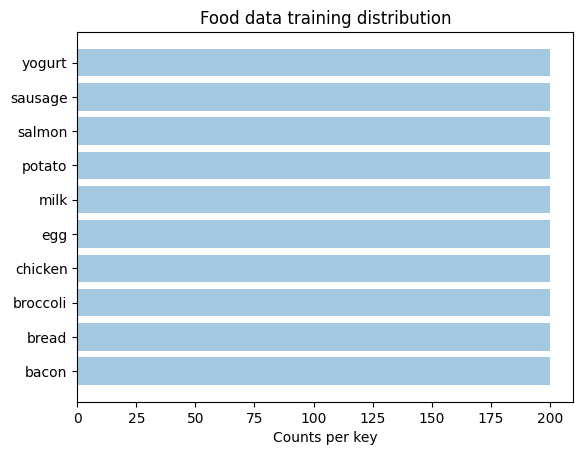

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plotCountsPerLabel(counter,title):
# Counter data, counter is your counter object
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    performance = [counter[k] for k in keys]
    # not sure if you want this :S
    

    plt.barh(y_pos, performance, align='center', alpha=0.4)
    plt.yticks(y_pos, keys)
    plt.xlabel('Counts per key')
    plt.title(title)

    plt.show()

trainfreq = Counter(trainLabels[y_values]) 
title = "Food data training distribution"
plotCountsPerLabel(trainfreq,title)


# Hyperparameter Modelling over different set of Models


In [17]:
import matplotlib.pyplot as plt

In [18]:
def plt_h(name,value):
  x = np.arange(len(name))
  plt.bar(x, value, align='center', alpha=0.5)
  plt.xticks(x, name)
  plt.ylabel('Accuracy')
  # Show plot
  plt.show()


In [19]:
record_path = 'input/TestData'
output_path = 'input/filteredOutputfood/'
filterTestFiles(record_path,output_path)

In [20]:

test_output_path = "input/filteredOutputfood/"
test_data_csv = 'input/testFood.csv'

X_test_pca , y_test = getTestfeaturesAndyValues(test_data_csv,test_output_path,label2index,TrainPCA,TrainScaler)


100%|██████████| 70/70 [00:01<00:00, 54.10it/s]

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7 8 8 8 8 8 8 8 9 9 9 9 9 9 9]
length of test y values =  70
shape of X_test_scaled =  (70, 216)


In [21]:
def str_label_int(output):
   y = np.array([label2index[x] for x in output])
   return y


## SVM Model 
1. Kernel : rbf, C value : 1

TrainPCA =  PCA(n_components=100)


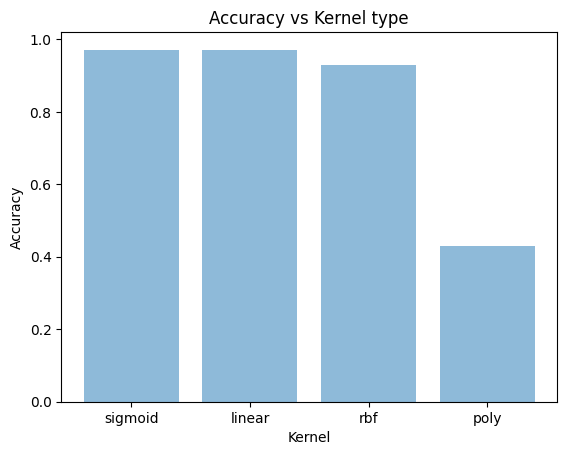

['sigmoid', 'linear', 'rbf', 'poly']
[0.9714285714285714, 0.9714285714285714, 0.9285714285714286, 0.42857142857142855]


In [22]:
print("TrainPCA = ",TrainPCA)
kernel_type = ['sigmoid','linear','rbf','poly']
acc_kernel = []
for i in kernel_type:
    clf, acc, report = getSVMmodel(X_pca,trainLabels[y_values],i,C_value=0.1)
    acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
    acc_kernel.append(acc)

plt.xlabel('Kernel')
plt.title('Accuracy vs Kernel type')
plt_h(kernel_type,acc_kernel)
print(kernel_type)
print(acc_kernel)

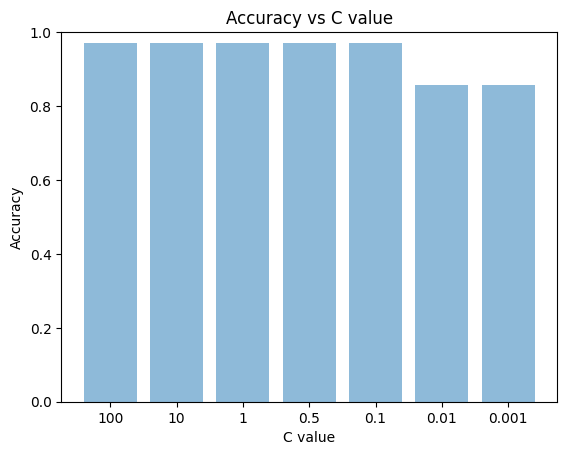

[100, 10, 1, 0.5, 0.1, 0.01, 0.001]
[0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.8571428571428571, 0.8571428571428571]


In [28]:
C_value = [100,10,1,0.5,0.1,0.01,0.001]
acc_C = []
for i in C_value:
    clf, acc, report = getSVMmodel(X_pca,trainLabels[y_values],'sigmoid',C_value=i)
    acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
    acc_C.append(acc)

plt.xlabel('C value')
plt.title('Accuracy vs C value')
plt.ylim(0,1)
plt_h(C_value,acc_C)
print(C_value)
print(acc_C)

## KNN Model
k = 5

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572, 0.9571428571428572]


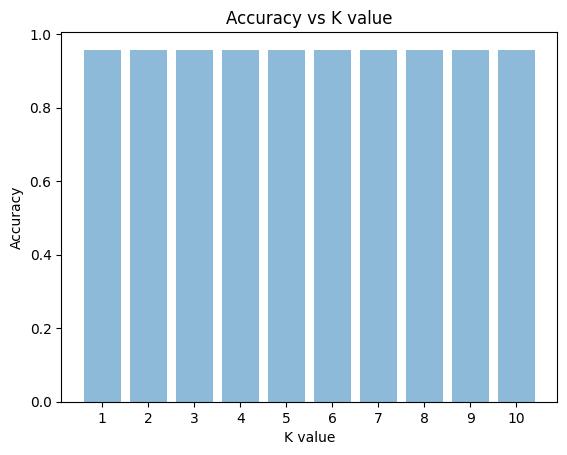

In [33]:
k = [1,2,3,4,5,6,7,8,9,10]
acc_k = []
for i in k:
  clf, acc, report = getKNNmodel(X_pca,trainLabels[y_values],k = i)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_k.append(acc)

plt.xlabel('K value')
plt.title('Accuracy vs K value')
print(k)
print(acc_k)
plt_h(k,acc_k)


## MLP Model

In [22]:
activation_func = ['identity', 'logistic', 'tanh', 'relu']
learning_rate_func = ['constant', 'invscaling','adaptive']
max_iter_func = [200,300,400,500,800,1000]
alpha_func = [0.0001,0.001,0.01,0.1,1]

c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\sit

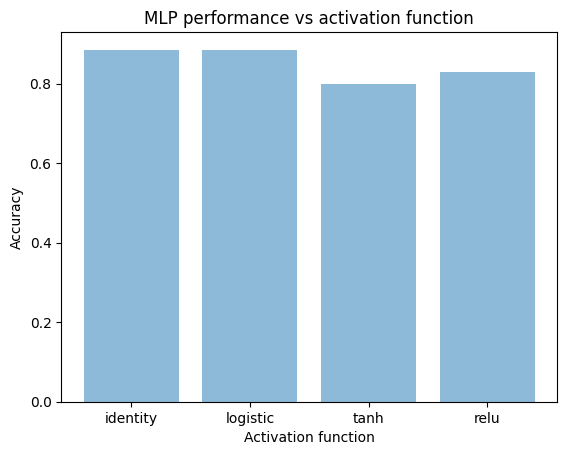

['identity', 'logistic', 'tanh', 'relu']
[0.8857142857142857, 0.8857142857142857, 0.8, 0.8285714285714286]


In [38]:
acc_act = []
for i in activation_func:
  clf, acc, report = getMLPmodel(X_pca,trainLabels[y_values],activation = i)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_act.append(acc)

plt.xlabel("Activation function")
plt.title("MLP performance vs activation function")
plt_h(activation_func,acc_act)

print(activation_func)
print(acc_act)


c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\sit

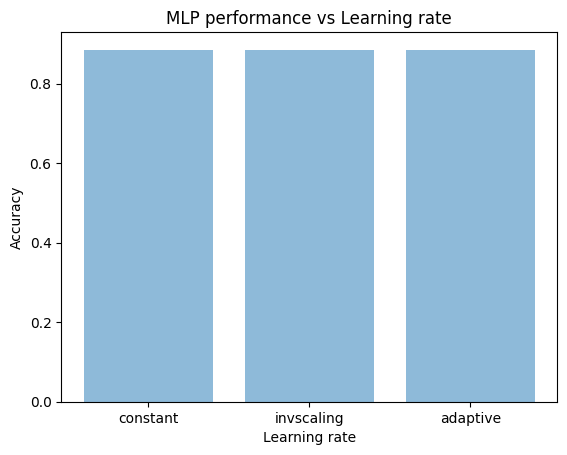

['constant', 'invscaling', 'adaptive']
[0.8857142857142857, 0.8857142857142857, 0.8857142857142857]


In [41]:
acc_act = []
for i in learning_rate_func:
  clf, acc, report = getMLPmodel(X_pca,trainLabels[y_values],learning_rate = i)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_act.append(acc)

plt.xlabel("Learning rate")
plt.title("MLP performance vs Learning rate")
plt_h(learning_rate_func,acc_act)

print(learning_rate_func)
print(acc_act)


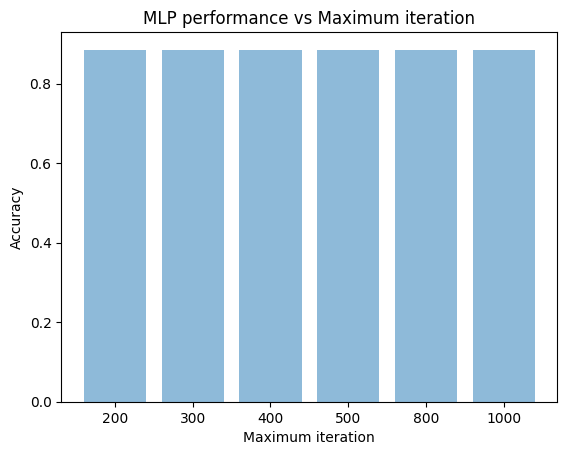

[200, 300, 400, 500, 800, 1000]
[0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857]


In [42]:
acc_act = []
for i in max_iter_func:
  clf, acc, report = getMLPmodel(X_pca,trainLabels[y_values],max_iter = i)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_act.append(acc)

plt.xlabel("Maximum iteration")
plt.title("MLP performance vs Maximum iteration")
plt_h(max_iter_func,acc_act)

print(max_iter_func)
print(acc_act)


c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\sit

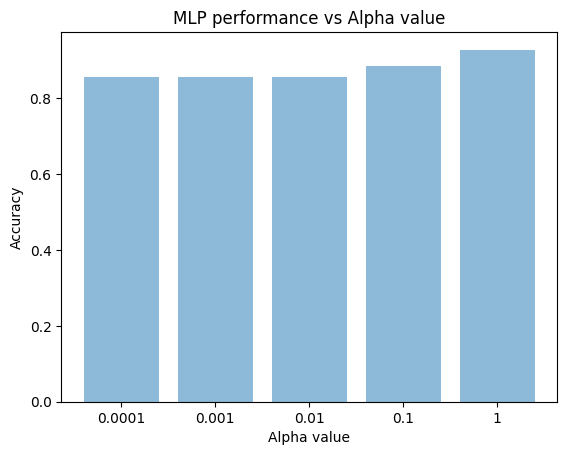

[0.0001, 0.001, 0.01, 0.1, 1]
[0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8857142857142857, 0.9285714285714286]


In [32]:
acc_act = []
for i in alpha_func:
  clf, acc, report = getMLPmodel(X_pca,trainLabels[y_values],alpha = i)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_act.append(acc)


plt.xlabel("Alpha value")
plt.title("MLP performance vs Alpha value")
plt_h(alpha_func,acc_act)

print(alpha_func)
print(acc_act)

## Random Forest Classifer

In [26]:
max_depth_func = [2,3,4,5,6,7,8,10,12,14,16,18]

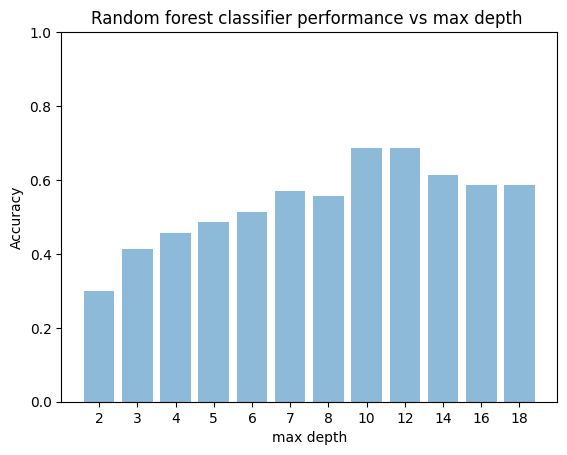

[2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18]
[0.3, 0.4142857142857143, 0.45714285714285713, 0.4857142857142857, 0.5142857142857142, 0.5714285714285714, 0.5571428571428572, 0.6857142857142857, 0.6857142857142857, 0.6142857142857143, 0.5857142857142857, 0.5857142857142857]


In [29]:
acc_depth = []
for i in max_depth_func:
  clf, acc, report = getRandomForestClassifier(X_pca,trainLabels[y_values],max_depth = i,max_features='log2',min_samples_leaf=5)
  acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
  acc_depth.append(acc)
plt.ylim(0,1)
plt.xlabel("max depth")
plt.title("Random forest classifier performance vs max depth ")
plt_h(max_depth_func,acc_depth)
print(max_depth_func)
print(acc_depth)

In [31]:
clf, acc, report = getRandomForestClassifier(X_pca,trainLabels[y_values],max_depth = 12,max_features='log2',min_samples_leaf=3)
RF_report = classification_report(clf.predict(X_test_pca), trainLabels[y_test])
print(RF_report)

              precision    recall  f1-score   support

       bacon       0.43      0.75      0.55         4
       bread       1.00      0.64      0.78        11
    broccoli       0.71      1.00      0.83         5
     chicken       0.57      0.36      0.44        11
         egg       0.57      1.00      0.73         4
        milk       0.43      0.60      0.50         5
      potato       0.57      0.67      0.62         6
      salmon       1.00      1.00      1.00         7
     sausage       0.57      0.80      0.67         5
      yogurt       1.00      0.58      0.74        12

    accuracy                           0.69        70
   macro avg       0.69      0.74      0.68        70
weighted avg       0.75      0.69      0.69        70



## Neural Network Architecture

In [23]:
print(X_test_pca.shape)
new_y = str_label_int(trainLabels[y_values])
print(new_y)
print(to_categorical(new_y,10).shape)

(70, 100)
[0 0 0 ... 9 9 9]
(2000, 10)


In [100]:
new_y = str_label_int(trainLabels[y_values])
model = seq_neuralmodel(X_pca,new_y)

Epoch 1/300
19/19 [==============================] - 1s 21ms/step - loss: 1.5090 - accuracy: 0.5259 - val_loss: 2.8302 - val_accuracy: 0.2052
Epoch 2/300
19/19 [==============================] - 0s 11ms/step - loss: 0.3191 - accuracy: 0.9543 - val_loss: 2.3602 - val_accuracy: 0.2879
Epoch 3/300
19/19 [==============================] - 0s 11ms/step - loss: 0.0707 - accuracy: 0.9970 - val_loss: 2.0644 - val_accuracy: 0.3414
Epoch 4/300
19/19 [==============================] - 0s 11ms/step - loss: 0.0315 - accuracy: 0.9987 - val_loss: 2.3541 - val_accuracy: 0.3310
Epoch 5/300
19/19 [==============================] - 0s 11ms/step - loss: 0.0193 - accuracy: 0.9991 - val_loss: 2.4357 - val_accuracy: 0.3310
Epoch 6/300
19/19 [==============================] - 0s 11ms/step - loss: 0.0123 - accuracy: 0.9996 - val_loss: 2.5447 - val_accuracy: 0.3500
Epoch 7/300
19/19 [==============================] - 0s 12ms/step - loss: 0.0112 - accuracy: 0.9991 - val_loss: 2.5569 - val_accuracy: 0.3569
Epoch 

In [101]:
new_y_test = to_categorical(str_label_int(trainLabels[y_test]))
model.evaluate(X_test_pca,new_y_test)

3/3 [==============================] - 0s 4ms/step - loss: 2.7174 - accuracy: 0.6892


[2.7173521518707275, 0.6891891956329346]

In [24]:
epochs_func = [50,100,150,200,500]
batch_size_func = [16,32,64,128]

Epoch 1/50
13/13 [==============================] - 0s 17ms/step - loss: 1.0748 - accuracy: 0.6919 - val_loss: 5.1869 - val_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0810 - accuracy: 0.9987 - val_loss: 6.5410 - val_accuracy: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 7.0388 - val_accuracy: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 7.2181 - val_accuracy: 0.0000e+00
Epoch 5/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 7.3041 - val_accuracy: 0.0000e+00
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 7.3619 - val_accuracy: 0.0000e+00
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.4130 - val_accuracy: 0.

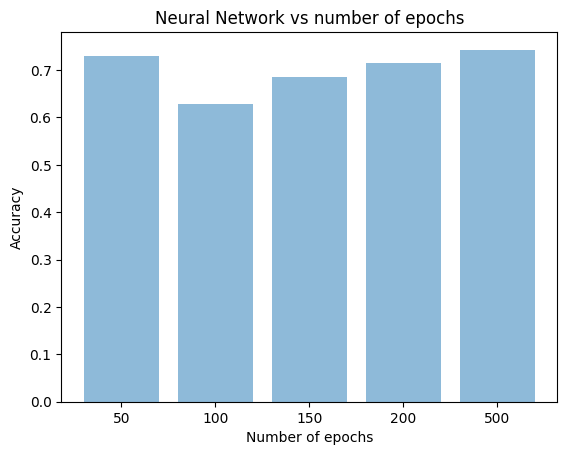

[50, 100, 150, 200, 500]
[0.7285714149475098, 0.6285714507102966, 0.6857143044471741, 0.7142857313156128, 0.7428571581840515]


In [27]:
acc_epo = []
for i in epochs_func:
  new_y = str_label_int(trainLabels[y_values])
  model = seq_neuralmodel(X_pca,new_y,epochs = i)
  new_y_test = to_categorical(str_label_int(trainLabels[y_test]))
  acc_epo.append(model.evaluate(X_test_pca,new_y_test)[1])
plt.title("Neural Network vs number of epochs")
plt.xlabel("Number of epochs")
plt_h(epochs_func,acc_epo)
print(epochs_func)
print(acc_epo)

Epoch 1/300
100/100 [==============================] - 1s 10ms/step - loss: 0.2842 - accuracy: 0.9237 - val_loss: 6.9592 - val_accuracy: 0.0000e+00
Epoch 2/300
100/100 [==============================] - 1s 9ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 7.4348 - val_accuracy: 0.0000e+00
Epoch 3/300
100/100 [==============================] - 1s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 7.6934 - val_accuracy: 0.0000e+00
Epoch 4/300
100/100 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.9100 - val_accuracy: 0.0000e+00
Epoch 5/300
100/100 [==============================] - 1s 9ms/step - loss: 9.4481e-04 - accuracy: 1.0000 - val_loss: 8.1675 - val_accuracy: 0.0000e+00
Epoch 6/300
100/100 [==============================] - 1s 9ms/step - loss: 5.8316e-04 - accuracy: 1.0000 - val_loss: 8.3253 - val_accuracy: 0.0000e+00
Epoch 7/300
100/100 [==============================] - 1s 9ms/step - loss: 4.5561e-04 - accuracy: 1.0000 - va

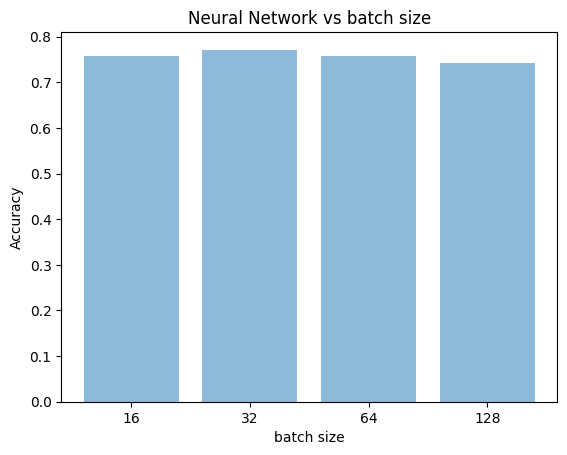

[50, 100, 150, 200, 500]
[0.6857143044471741, 0.6857143044471741, 0.7285714149475098, 0.699999988079071, 0.699999988079071]


In [33]:
acc_batch = []
for i in batch_size_func:
  new_y = str_label_int(trainLabels[y_values])
  model = seq_neuralmodel(X_pca,new_y,batch_size =i )
  new_y_test = to_categorical(str_label_int(trainLabels[y_test]))
  acc_batch.append(model.evaluate(X_test_pca,new_y_test)[1])



plt.title("Neural Network vs batch size")
plt.xlabel("batch size")
plt_h(batch_size_func ,acc_batch) #22 min
print(epochs_func)
print(acc_epo)

In [34]:
print(batch_size_func)
print(acc_batch)

[16, 32, 64, 128]
[0.7571428418159485, 0.7714285850524902, 0.7571428418159485, 0.7428571581840515]


## Model Comparison

In [28]:
clf,_,report = getSVMmodel(X_pca,trainLabels[y_values])
clf2,_,report2 =  getMLPmodel(X_pca,trainLabels[y_values])
clf_food = clf2
clf3,_,report3 =  getKNNmodel(X_pca,trainLabels[y_values])
clf4,_,report4 =  getRandomForestClassifier(X_pca,trainLabels[y_values])

c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:

new_y = str_label_int(trainLabels[y_values])
model = seq_neuralmodel(X_pca,new_y)


acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
acc2 = accuracy_score(clf2.predict(X_test_pca), trainLabels[y_test])
acc3 = accuracy_score(clf3.predict(X_test_pca), trainLabels[y_test])
acc4 = accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test])
new_y_test = to_categorical(str_label_int(trainLabels[y_test]))
acc5 = model.evaluate(X_test_pca,new_y_test)[1]

vacc_lis = [acc*100,acc2*100,acc3*100,acc4*100,acc5*100]
model_name = ['SVM','MLP','KNN','RandomForestClassifier','NeuralNet']

Epoch 1/150
13/13 [==============================] - 1s 19ms/step - loss: 0.9318 - accuracy: 0.7606 - val_loss: 4.9404 - val_accuracy: 0.0000e+00
Epoch 2/150
13/13 [==============================] - 0s 12ms/step - loss: 0.0598 - accuracy: 0.9975 - val_loss: 6.1538 - val_accuracy: 0.0000e+00
Epoch 3/150
13/13 [==============================] - 0s 12ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 6.6396 - val_accuracy: 0.0000e+00
Epoch 4/150
13/13 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 6.8256 - val_accuracy: 0.0000e+00
Epoch 5/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 6.8960 - val_accuracy: 0.0000e+00
Epoch 6/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 6.9349 - val_accuracy: 0.0000e+00
Epoch 7/150
13/13 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.9684 - val

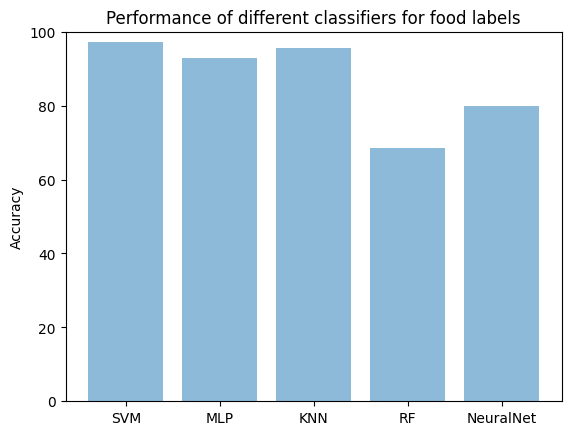

[97.14285714285714, 92.85714285714286, 95.71428571428572, 68.57142857142857, 80.0000011920929]


In [30]:
model_name = ['SVM','MLP','KNN','RF','NeuralNet']
plt.ylim(0,100)
plt.title("Performance of different classifiers for food labels")
plt_h(model_name ,vacc_lis)
print(vacc_lis)

# Each Class Accuracy

## Neural Network

In [31]:
#print(np.max(model.predict(X_test_pca),axis=1))
maxValues = np.max(model.predict(X_test_pca),axis=1)
predict = model.predict(X_test_pca)
index = np.argmax(predict,axis =1)
#print(index)
NN_report = classification_report(trainLabels[index], trainLabels[y_test])
print(NN_report) #overfitting

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       bacon       1.00      1.00      1.00         7
       bread       1.00      1.00      1.00         7
    broccoli       1.00      0.88      0.93         8
     chicken       1.00      0.70      0.82        10
         egg       1.00      1.00      1.00         7
        milk       1.00      1.00      1.00         7
      potato       1.00      0.78      0.88         9
      salmon       1.00      0.47      0.64        15
     sausage       0.00      0.00      0.00         0
      yogurt       0.00      0.00      0.00         0

    accuracy                           0.80        70
   macro avg       0.80      0.68      0.73        70
weighted avg       1.00      0.80      0.87        70



c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [32]:
SVM_report = classification_report(clf.predict(X_test_pca), trainLabels[y_test])

print(SVM_report)


              precision    recall  f1-score   support

       bacon       1.00      0.78      0.88         9
       bread       1.00      1.00      1.00         7
    broccoli       1.00      1.00      1.00         7
     chicken       1.00      1.00      1.00         7
         egg       0.71      1.00      0.83         5
        milk       1.00      1.00      1.00         7
      potato       1.00      1.00      1.00         7
      salmon       1.00      1.00      1.00         7
     sausage       1.00      1.00      1.00         7
      yogurt       1.00      1.00      1.00         7

    accuracy                           0.97        70
   macro avg       0.97      0.98      0.97        70
weighted avg       0.98      0.97      0.97        70



# MLP

In [34]:
MLP_report = classification_report(clf2.predict(X_test_pca), trainLabels[y_test])
print(MLP_report)


              precision    recall  f1-score   support

       bacon       0.57      1.00      0.73         4
       bread       1.00      0.78      0.88         9
    broccoli       1.00      1.00      1.00         7
     chicken       0.71      0.62      0.67         8
         egg       1.00      1.00      1.00         7
        milk       1.00      1.00      1.00         7
      potato       1.00      1.00      1.00         7
      salmon       1.00      1.00      1.00         7
     sausage       1.00      1.00      1.00         7
      yogurt       1.00      1.00      1.00         7

    accuracy                           0.93        70
   macro avg       0.93      0.94      0.93        70
weighted avg       0.94      0.93      0.93        70



## KNN

In [35]:
KNN_report = classification_report(clf3.predict(X_test_pca), trainLabels[y_test])
print("KNN report")
print(KNN_report)

KNN report
              precision    recall  f1-score   support

       bacon       1.00      1.00      1.00         7
       bread       1.00      0.78      0.88         9
    broccoli       1.00      1.00      1.00         7
     chicken       0.57      1.00      0.73         4
         egg       1.00      1.00      1.00         7
        milk       1.00      0.88      0.93         8
      potato       1.00      1.00      1.00         7
      salmon       1.00      1.00      1.00         7
     sausage       1.00      1.00      1.00         7
      yogurt       1.00      1.00      1.00         7

    accuracy                           0.96        70
   macro avg       0.96      0.97      0.95        70
weighted avg       0.98      0.96      0.96        70



# RF

In [36]:
RF_report = classification_report(clf4.predict(X_test_pca), trainLabels[y_test])
print(RF_report)

              precision    recall  f1-score   support

       bacon       0.43      0.75      0.55         4
       bread       1.00      0.64      0.78        11
    broccoli       0.71      1.00      0.83         5
     chicken       0.57      0.36      0.44        11
         egg       0.57      1.00      0.73         4
        milk       0.43      0.60      0.50         5
      potato       0.57      0.67      0.62         6
      salmon       1.00      1.00      1.00         7
     sausage       0.57      0.80      0.67         5
      yogurt       1.00      0.58      0.74        12

    accuracy                           0.69        70
   macro avg       0.69      0.74      0.68        70
weighted avg       0.75      0.69      0.69        70



In [37]:
def getWordAccuracyDict(cm,labels):
    wordAcc = {}
    for i,label in enumerate(labels):
        
        wordAcc[label] = round(cm[i][i]/np.sum(cm[i]),2)
    return wordAcc

In [38]:
def get_ACC_from_CM(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal()

#SVM
labels = [0,1,2,3,4,5,6,7,8,9]
cm_SVM = confusion_matrix(y_test, str_label_int(clf.predict(X_test_pca)), labels=labels)
cm_MLP = confusion_matrix(y_test, str_label_int(clf2.predict(X_test_pca)), labels=labels)
cm_KNN = confusion_matrix(y_test, str_label_int(clf3.predict(X_test_pca)), labels=labels)
cm_RF = confusion_matrix(y_test, str_label_int(clf4.predict(X_test_pca)), labels=labels)

ACC = {}
ACC['SVM'] = getWordAccuracyDict(cm_SVM,trainLabels)
ACC['MLP'] = getWordAccuracyDict(cm_MLP,trainLabels)


In [39]:
labels = [0,1,2,3,4,5,6,7,8,9]

SVM Classifier

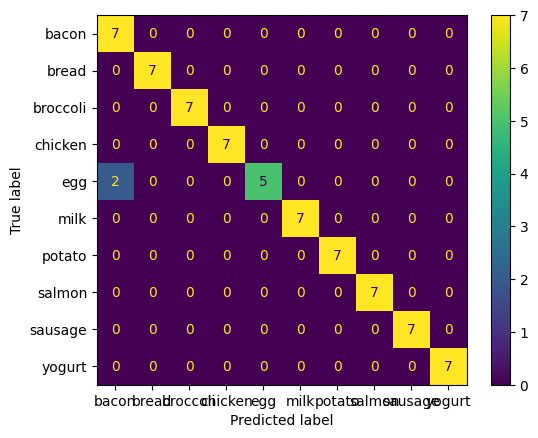

SVM Classifier
raw acc =  0.9714285714285714
Word Accuracy {'bacon': 1.0, 'bread': 1.0, 'broccoli': 1.0, 'chicken': 1.0, 'egg': 0.71, 'milk': 1.0, 'potato': 1.0, 'salmon': 1.0, 'sausage': 1.0, 'yogurt': 1.0}


In [40]:

clf,_,report = getSVMmodel(X_pca,trainLabels[y_values]) ###
cm = confusion_matrix(y_test, str_label_int(clf.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm,display_labels = trainLabels)
disp.plot()
plt.show()
print("SVM Classifier")

print("raw acc = ",accuracy_score(clf.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm,trainLabels))


MLP Classifier

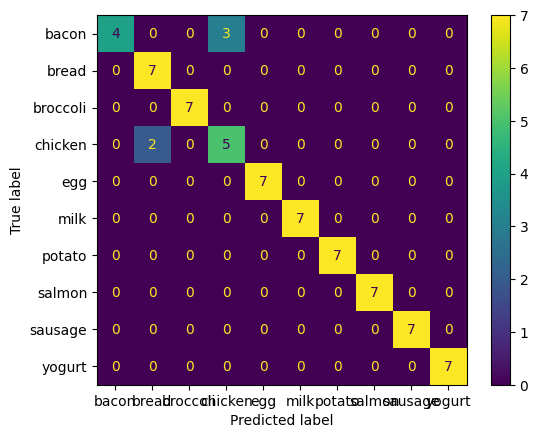

MLP Classifier
raw acc =  0.9285714285714286
Word Accuracy {'bacon': 0.57, 'bread': 1.0, 'broccoli': 1.0, 'chicken': 0.71, 'egg': 1.0, 'milk': 1.0, 'potato': 1.0, 'salmon': 1.0, 'sausage': 1.0, 'yogurt': 1.0}


In [41]:
cm2 = confusion_matrix(y_test, str_label_int(clf2.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm2,display_labels = trainLabels)
disp.plot()
plt.show()
print("MLP Classifier")
print("raw acc = ",accuracy_score(clf2.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm2,trainLabels))

KNN Classifier

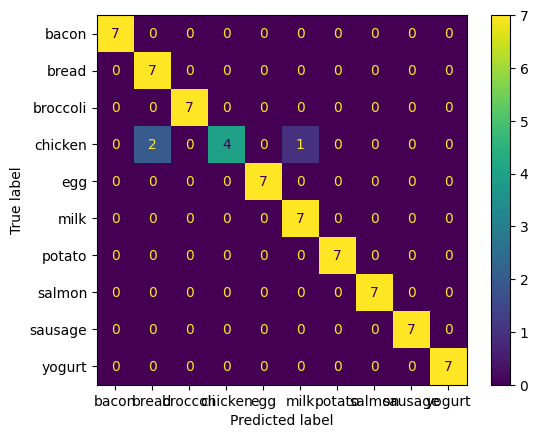

KNN Classifier
raw acc =  0.9571428571428572
Word Accuracy {'bacon': 1.0, 'bread': 1.0, 'broccoli': 1.0, 'chicken': 0.57, 'egg': 1.0, 'milk': 1.0, 'potato': 1.0, 'salmon': 1.0, 'sausage': 1.0, 'yogurt': 1.0}


In [42]:
cm3 = confusion_matrix(y_test, str_label_int(clf3.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm3,display_labels = trainLabels)
disp.plot()
plt.show()
print("KNN Classifier")
print("raw acc = ",accuracy_score(clf3.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm3,trainLabels))

RF Classifier

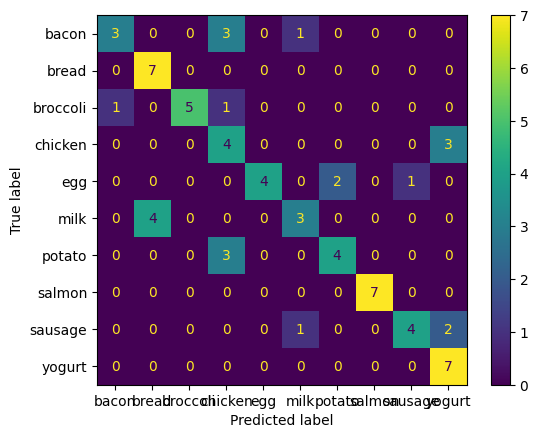

RF Classifier
raw acc =  0.6857142857142857
Word Accuracy {0: 0.43, 1: 1.0, 2: 0.71, 3: 0.57, 4: 0.57, 5: 0.43, 6: 0.57, 7: 1.0, 8: 0.57, 9: 1.0}


In [43]:
cm4 = confusion_matrix(y_test, str_label_int(clf4.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm4,display_labels = trainLabels)
disp.plot()
plt.show()
print("RF Classifier")
print("raw acc = ",accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm4,labels))

Neural Net Classifer

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       bacon       1.00      1.00      1.00         7
       bread       1.00      1.00      1.00         7
    broccoli       1.00      0.88      0.93         8
     chicken       1.00      0.70      0.82        10
         egg       1.00      1.00      1.00         7
        milk       1.00      1.00      1.00         7
      potato       1.00      0.78      0.88         9
      salmon       1.00      0.47      0.64        15
     sausage       0.00      0.00      0.00         0
      yogurt       0.00      0.00      0.00         0

    accuracy                           0.80        70
   macro avg       0.80      0.68      0.73        70
weighted avg       1.00      0.80      0.87        70



c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


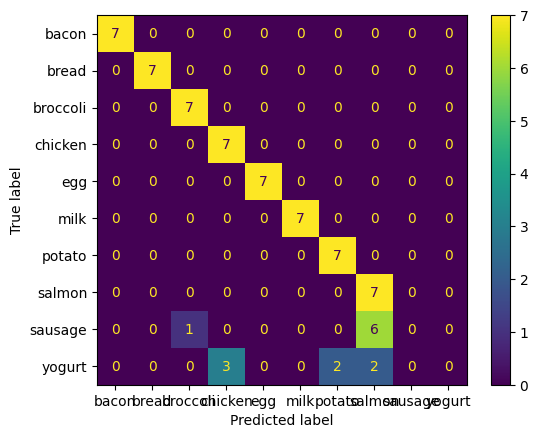

In [44]:
#print(np.max(model.predict(X_test_pca),axis=1))
maxValues = np.max(model.predict(X_test_pca),axis=1)
predict = model.predict(X_test_pca)
index = np.argmax(predict,axis =1)
#print(index)
NN_report = classification_report(trainLabels[index], trainLabels[y_test])
print(NN_report) #overfitting

#change this to neural net
cm4 = confusion_matrix(y_test,index, labels=labels)
disp = ConfusionMatrixDisplay(cm4,display_labels = trainLabels)
disp.plot()

#print("SVM Classifier")
#print("raw acc = ",accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test]))
#print('Word Accuracy',getWordAccuracyDict(cm4,labels))

**Display Results**

In [45]:
def plot_cm(x,y,model):
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42, shuffle = True)
    ConfusionMatrixDisplay(model, X_val, y_val)  
    plt.show()


In [46]:
def getWordAccuracyDict(cm,labels):
    wordAcc = {}
    for i,label in enumerate(labels):
        wordAcc[label] = round(cm[i][i]/np.sum(cm[i]),2)
    return wordAcc

In [47]:
from collections import Counter


X_train, X_val, y_train, y_val = train_test_split(X_pca, y_values, test_size = 0.2, random_state = 42,stratify= y_values)
trainfreq = Counter(trainLabels[y_values]) 
for label in trainLabels:
    print(label,round(trainfreq[label]/25,2))
print(trainfreq)
print("test vlaues = ",Counter(trainLabels[y_val]))

bacon 8.0
bread 8.0
broccoli 8.0
chicken 8.0
egg 8.0
milk 8.0
potato 8.0
salmon 8.0
sausage 8.0
yogurt 8.0
Counter({'bacon': 200, 'bread': 200, 'broccoli': 200, 'chicken': 200, 'egg': 200, 'milk': 200, 'potato': 200, 'salmon': 200, 'sausage': 200, 'yogurt': 200})
test vlaues =  Counter({'salmon': 40, 'potato': 40, 'bread': 40, 'broccoli': 40, 'milk': 40, 'egg': 40, 'sausage': 40, 'yogurt': 40, 'chicken': 40, 'bacon': 40})


## **Number Classifier**

In [21]:
record_path = 'AugmentedFile/'
output_path = 'input/filteredTrainingData/'
lowcut = 10
highcut = 4000
FRAME_RATE = 16000

FilterAudioFiles(record_path,output_path,lowcut,highcut,FRAME_RATE)

In [53]:
audio_train_files_dir = 'input/filteredTrainingData/'
train_csv = 'input/augmented_files_numbers.csv'

X_pca,label2index_num,TrainPCA_num,y_values,trainLabels,TrainScaler,means_num,stds_num = getFeaturesAndTrainPCA(audio_train_files_dir,train_csv)

100%|██████████| 3250/3250 [00:53<00:00, 61.10it/s]


done loading train mfcc
feature_names =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

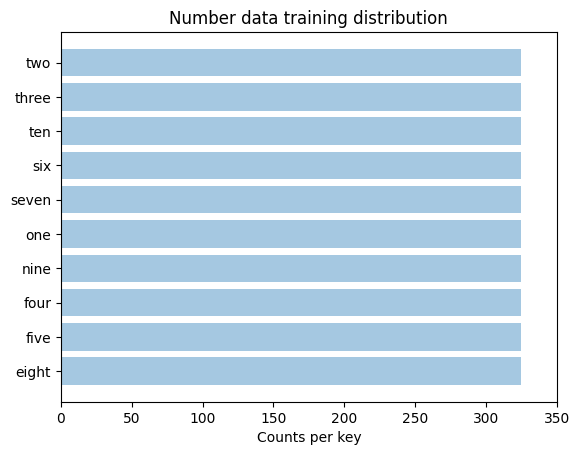

In [54]:
trainfreq = Counter(trainLabels[y_values]) 
title = "Number data training distribution"
plt.xlim(0,350)
plotCountsPerLabel(trainfreq,title)


In [55]:
def str_label_int_num(output):
   y = np.array([label2index_num[x] for x in output])
   return y


In [56]:
record_path = 'input/testDataNumbers'
output_path = "input/filteredTestDataNumbers/"
lowcut = 25
highcut = 2500
FRAME_RATE = 16000
filterTestFiles(record_path,output_path)

In [57]:

test_output_path = "input/filteredTestDataNumbers/"
test_data_csv = 'input/TestNumbers.csv'


X_test_pca , y_test = getTestfeaturesAndyValues(test_data_csv,test_output_path,label2index_num,TrainPCA_num,TrainScaler)


100%|██████████| 70/70 [00:01<00:00, 60.67it/s]

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7 8 8 8 8 8 8 8 9 9 9 9 9 9 9]
length of test y values =  70
shape of X_test_scaled =  (70, 216)


# Model Comparison

In [58]:
def str_label_int_num(output):
   y = np.array([label2index_num[x] for x in output])
   return y

In [59]:
print(trainLabels[y_values])

['eight' 'eight' 'eight' ... 'two' 'two' 'two']


In [60]:
print(trainLabels)
new_y = str_label_int_num(trainLabels[y_values])
print(np.unique(new_y))
print(np.max(np.array(new_y)))
model = seq_neuralmodel(X_pca,new_y)

['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'ten' 'three' 'two']
[0 1 2 3 4 5 6 7 8 9]
9
Epoch 1/150
21/21 [==============================] - 1s 14ms/step - loss: 0.9155 - accuracy: 0.7665 - val_loss: 6.1245 - val_accuracy: 0.0000e+00
Epoch 2/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 7.1120 - val_accuracy: 0.0000e+00
Epoch 3/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 7.3474 - val_accuracy: 0.0000e+00
Epoch 4/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 7.4141 - val_accuracy: 0.0000e+00
Epoch 5/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 7.4317 - val_accuracy: 0.0000e+00
Epoch 6/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 7.4601 - val_accuracy: 0.0000e+00
Epoch 7/150
21/21 [===============

In [61]:
clf,_,report = getSVMmodel(X_pca,trainLabels[y_values])

clf2,_,report2 =  getMLPmodel(X_pca,trainLabels[y_values])
clf3,_,report3 =  getKNNmodel(X_pca,trainLabels[y_values])
clf4,_,report4 =  getRandomForestClassifier(X_pca,trainLabels[y_values])
clf_num = clf




In [62]:
new_y = str_label_int_num(trainLabels[y_values])
print(np.max(np.array(new_y)))
model = seq_neuralmodel(X_pca,new_y)


acc = accuracy_score(clf.predict(X_test_pca), trainLabels[y_test])
acc2 = accuracy_score(clf2.predict(X_test_pca), trainLabels[y_test])
acc3 = accuracy_score(clf3.predict(X_test_pca), trainLabels[y_test])
acc4 = accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test])
new_y_test = to_categorical(str_label_int_num(trainLabels[y_test]))
acc5 = model.evaluate(X_test_pca,new_y_test)[1]

vacc_lis = [acc*100,acc2*100,acc3*100,acc4*100,acc5*100]
model_name = ['SVM','MLP','KNN','RandomForestClassifier','NeuralNet']


9
Epoch 1/150
21/21 [==============================] - 1s 14ms/step - loss: 0.7376 - accuracy: 0.8123 - val_loss: 5.2011 - val_accuracy: 0.0000e+00
Epoch 2/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9988 - val_loss: 6.1057 - val_accuracy: 0.0000e+00
Epoch 3/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 6.2888 - val_accuracy: 0.0000e+00
Epoch 4/150
21/21 [==============================] - 0s 11ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 6.3515 - val_accuracy: 0.0000e+00
Epoch 5/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 6.4081 - val_accuracy: 0.0000e+00
Epoch 6/150
21/21 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 6.4555 - val_accuracy: 0.0000e+00
Epoch 7/150
21/21 [==============================] - 0s 10ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.4903 - val_a

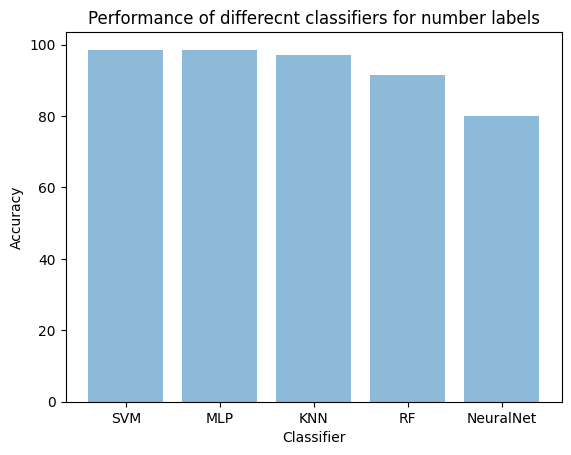

[98.57142857142858, 98.57142857142858, 97.14285714285714, 91.42857142857143, 80.0000011920929]


In [63]:
model_name = ['SVM','MLP','KNN','RF','NeuralNet']
plt.title("Performance of differecnt classifiers for number labels")
plt.xlabel("Classifier")
plt_h(model_name ,vacc_lis)
print(vacc_lis)

# Each Class Accuracy

SVM

In [64]:
SVM_report = classification_report(clf.predict(X_test_pca), trainLabels[y_test])
print(SVM_report)


              precision    recall  f1-score   support

       eight       1.00      1.00      1.00         7
        five       1.00      1.00      1.00         7
        four       1.00      1.00      1.00         7
        nine       1.00      0.88      0.93         8
         one       1.00      1.00      1.00         7
       seven       1.00      1.00      1.00         7
         six       1.00      1.00      1.00         7
         ten       1.00      1.00      1.00         7
       three       0.86      1.00      0.92         6
         two       1.00      1.00      1.00         7

    accuracy                           0.99        70
   macro avg       0.99      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



In [65]:
cm = confusion_matrix(trainLabels[y_test], clf.predict(X_test_pca))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.85714286, 1.        ])

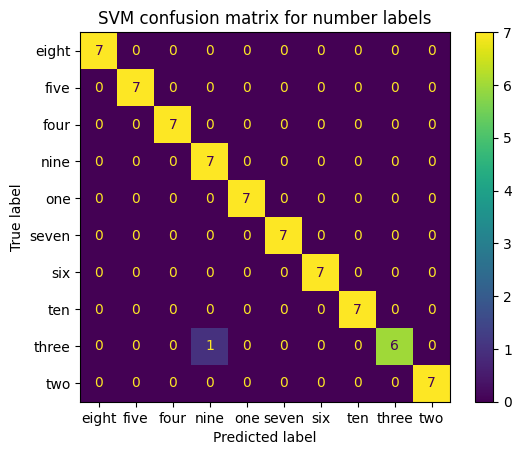

SVM Classifier
raw acc =  0.9857142857142858
Word Accuracy {'eight': 1.0, 'five': 1.0, 'four': 1.0, 'nine': 1.0, 'one': 1.0, 'seven': 1.0, 'six': 1.0, 'ten': 1.0, 'three': 0.86, 'two': 1.0}


In [66]:

cm = confusion_matrix(y_test, str_label_int_num(clf.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm,display_labels = trainLabels)
disp.plot()
plt.title("SVM confusion matrix for number labels")
plt.show()
print("SVM Classifier")

print("raw acc = ",accuracy_score(clf.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm,trainLabels))

MLP

In [67]:
MLP_report = classification_report(clf2.predict(X_test_pca), trainLabels[y_test])
print(MLP_report)

              precision    recall  f1-score   support

       eight       1.00      1.00      1.00         7
        five       1.00      1.00      1.00         7
        four       1.00      1.00      1.00         7
        nine       1.00      0.88      0.93         8
         one       1.00      1.00      1.00         7
       seven       1.00      1.00      1.00         7
         six       1.00      1.00      1.00         7
         ten       1.00      1.00      1.00         7
       three       0.86      1.00      0.92         6
         two       1.00      1.00      1.00         7

    accuracy                           0.99        70
   macro avg       0.99      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



In [68]:
cm = confusion_matrix(trainLabels[y_test], clf2.predict(X_test_pca))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.85714286, 1.        ])

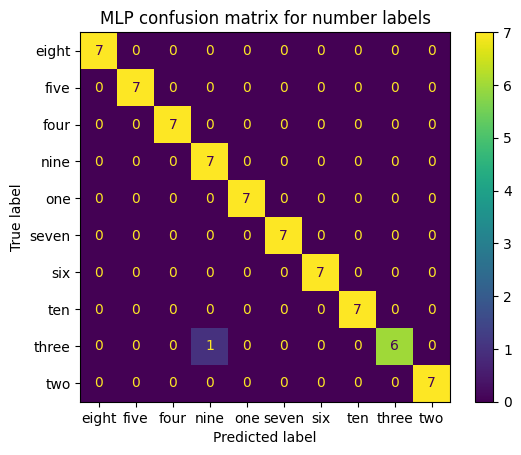

MLP Classifier
raw acc =  0.9857142857142858
Word Accuracy {'eight': 1.0, 'five': 1.0, 'four': 1.0, 'nine': 1.0, 'one': 1.0, 'seven': 1.0, 'six': 1.0, 'ten': 1.0, 'three': 0.86, 'two': 1.0}


In [69]:

cm = confusion_matrix(y_test, str_label_int_num(clf2.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm,display_labels = trainLabels)
disp.plot()
plt.title("MLP confusion matrix for number labels")
plt.show()
print("MLP Classifier")

print("raw acc = ",accuracy_score(clf.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm,trainLabels))

KNN

In [70]:
KNN_report = classification_report(clf3.predict(X_test_pca), trainLabels[y_test])
print(KNN_report)

              precision    recall  f1-score   support

       eight       1.00      1.00      1.00         7
        five       1.00      1.00      1.00         7
        four       1.00      1.00      1.00         7
        nine       1.00      0.88      0.93         8
         one       1.00      0.88      0.93         8
       seven       0.86      1.00      0.92         6
         six       1.00      1.00      1.00         7
         ten       1.00      1.00      1.00         7
       three       0.86      1.00      0.92         6
         two       1.00      1.00      1.00         7

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.98      0.97      0.97        70



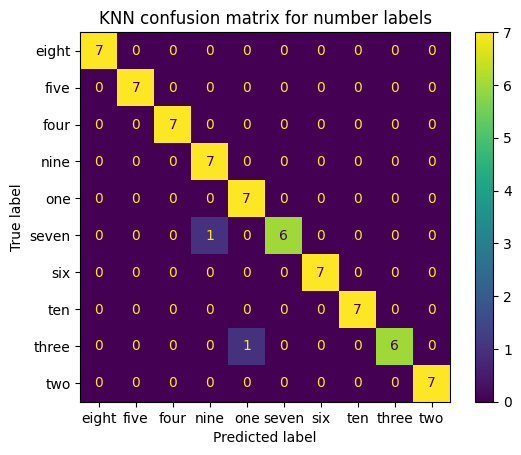

KNN Classifier
raw acc =  0.9714285714285714
Word Accuracy {'eight': 1.0, 'five': 1.0, 'four': 1.0, 'nine': 1.0, 'one': 1.0, 'seven': 0.86, 'six': 1.0, 'ten': 1.0, 'three': 0.86, 'two': 1.0}


In [71]:

cm = confusion_matrix(y_test, str_label_int_num(clf3.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm,display_labels = trainLabels)
disp.plot()
plt.title("KNN confusion matrix for number labels")
plt.show()
print("KNN Classifier")

print("raw acc = ",accuracy_score(clf3.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm,trainLabels))

In [72]:
cm = confusion_matrix(trainLabels[y_test], clf3.predict(X_test_pca))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.85714286, 1.        , 1.        , 0.85714286, 1.        ])

RF

In [73]:
RF_report = classification_report(clf4.predict(X_test_pca), trainLabels[y_test])
print(RF_report)


              precision    recall  f1-score   support

       eight       1.00      0.78      0.88         9
        five       0.86      0.86      0.86         7
        four       1.00      1.00      1.00         7
        nine       1.00      0.88      0.93         8
         one       1.00      1.00      1.00         7
       seven       1.00      1.00      1.00         7
         six       0.57      1.00      0.73         4
         ten       0.86      0.86      0.86         7
       three       0.86      1.00      0.92         6
         two       1.00      0.88      0.93         8

    accuracy                           0.91        70
   macro avg       0.91      0.92      0.91        70
weighted avg       0.93      0.91      0.92        70



In [74]:
cm = confusion_matrix(trainLabels[y_test], clf4.predict(X_test_pca))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([1.        , 0.85714286, 1.        , 1.        , 1.        ,
       1.        , 0.57142857, 0.85714286, 0.85714286, 1.        ])

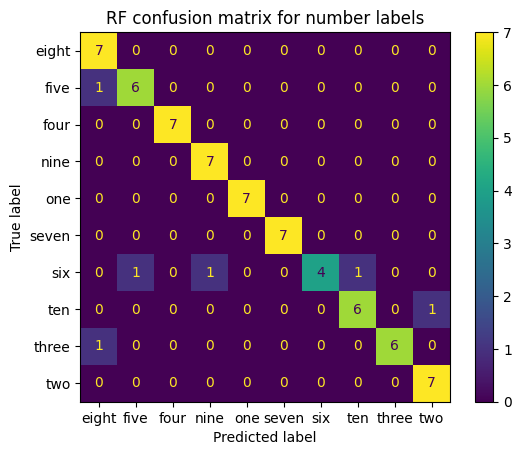

SVM Classifier
raw acc =  0.9142857142857143
Word Accuracy {'eight': 1.0, 'five': 0.86, 'four': 1.0, 'nine': 1.0, 'one': 1.0, 'seven': 1.0, 'six': 0.57, 'ten': 0.86, 'three': 0.86, 'two': 1.0}


In [75]:

cm = confusion_matrix(y_test, str_label_int_num(clf4.predict(X_test_pca)), labels=labels)
disp = ConfusionMatrixDisplay(cm,display_labels = trainLabels)
disp.plot()
plt.title("RF confusion matrix for number labels")
plt.show()
print("SVM Classifier")
    
print("raw acc = ",accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test]))
print('Word Accuracy',getWordAccuracyDict(cm,trainLabels))

## Neural Network


3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       eight       1.00      0.88      0.93         8
        five       1.00      1.00      1.00         7
        four       1.00      1.00      1.00         7
        nine       1.00      0.88      0.93         8
         one       1.00      0.70      0.82        10
       seven       1.00      1.00      1.00         7
         six       1.00      1.00      1.00         7
         ten       1.00      0.44      0.61        16
       three       0.00      0.00      0.00         0
         two       0.00      0.00      0.00         0

    accuracy                           0.80        70
   macro avg       0.80      0.69      0.73        70
weighted avg       1.00      0.80      0.87        70



c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kesav\anaconda3\envs\IP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


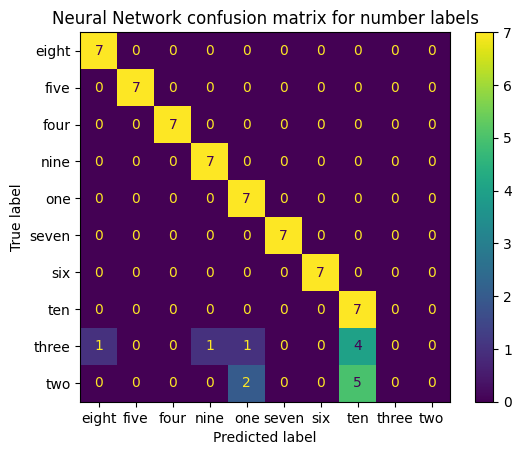

In [76]:
#print(np.max(model.predict(X_test_pca),axis=1))
maxValues = np.max(model.predict(X_test_pca),axis=1)
predict = model.predict(X_test_pca)
index = np.argmax(predict,axis =1)
#print(index)
NN_report = classification_report(trainLabels[index], trainLabels[y_test])
print(NN_report) #overfitting

#change this to neural net
cm4 = confusion_matrix(y_test,index, labels=labels)
disp = ConfusionMatrixDisplay(cm4,display_labels = trainLabels)

disp.plot()
plt.title("Neural Network confusion matrix for number labels")
plt.show()

#print("SVM Classifier")
#print("raw acc = ",accuracy_score(clf4.predict(X_test_pca), trainLabels[y_test]))
#print('Word Accuracy',getWordAccuracyDict(cm4,labels))

# **Nutritional Calculator**

Data


In [77]:
df = pd.read_csv('input/nutritionFeaturesExtractedFormatted.csv')
df

,Nutritional_groups,Bacon,Bread,Broccoli,Chicken,Egg,Milk,Potato,Salmon,Sausage,Yoghurt
0,Calcium,8.000,177.000,35.00,7.000,53.000,120.000,11.000,11.000,110.000,126.000
1,Carbohydrate,0.000,46.100,2.80,0.000,0.000,4.700,22.600,0.000,9.800,4.800
2,Chloride,2060.000,720.000,180.00,66.000,188.000,87.000,114.000,86.000,980.000,159.000
3,Copper,0.070,0.140,0.05,0.060,0.060,0.000,0.090,0.050,0.110,0.000
4,Energy_kcal,307.000,219.000,28.00,147.000,200.000,46.000,97.000,232.000,294.000,133.000
5,Energy_MJ,1.276,0.931,0.12,0.621,0.831,0.195,0.413,0.969,1.221,0.551
6,Fat,23.100,1.600,0.50,3.100,15.700,1.700,0.200,14.600,22.100,10.200
7,Fibre,0.000,2.500,2.80,0.000,0.000,0.000,2.600,0.000,2.300,0.000
8,Folate,3.000,25.000,34.00,5.000,25.000,9.000,18.000,8.000,4.000,18.000
9,Iodine,8.000,4.000,2.00,6.000,58.000,30.000,1.000,14.000,8.000,39.000


In [78]:
elements = df['Nutritional_groups']
print(list(elements))

['Calcium', 'Carbohydrate', 'Chloride', 'Copper', 'Energy_kcal', 'Energy_MJ', 'Fat', 'Fibre', 'Folate', 'Iodine', 'Iron', 'Magnesium', 'MonoUnsaturatedFat', 'NiacinEq', 'Phosphorus', 'PolyUnsaturatedFat', 'Potassium', 'Protein', 'Riboflavin', 'SaturatedFat', 'Selenium', 'Sodium', 'Sugars', 'Thiamin', 'VitaminA', 'VitaminB12', 'VitaminB6', 'VitaminC', 'VitaminD', 'Zinc']


In [79]:
index2label = {v: k for k, v in label2index.items()}
print(index2label)

{0: 'bacon', 1: 'bread', 2: 'broccoli', 3: 'chicken', 4: 'egg', 5: 'milk', 6: 'potato', 7: 'salmon', 8: 'sausage', 9: 'yogurt'}


In [80]:
def per_unit_food(food,units):
  if food == "yogurt":
    food = "Yoghurt"
  else:
    food = food.capitalize()
  nutrition_data = list(df[food])
  return [x * units for x in nutrition_data]



In [81]:
def input_feature_food(wav_file):
  train_data = get_mfccV2("",wav_file)
  X = np.array(train_data).reshape(1, -1)
  X_scaled = (X - means_food) / stds_food
  #TrainPCA = 0
  output = TrainPCA.transform(X_scaled)
  return output



In [82]:
def input_feature_num(wav_file):
  train_data = get_mfccV2("",wav_file)
  X = np.array(train_data).reshape(1, -1)
  X_scaled = (X - means_num) / stds_num
  #TrainPCA = 0
  output = TrainPCA_num.transform(X_scaled)
  return output

In [83]:
def label_int_num(output):
   label2num = {'eight': 8, 'five': 5, 'four': 4, 'nine': 9, 'one': 1, 'seven': 7, 'six': 6, 'ten': 10, 'three': 3, 'two': 2}
   y = label2num[output]
   return y
 
def get_data(food_wav,number_wav):
  
  X_food = input_feature_food(food_wav)
  X_num = input_feature_num(number_wav)
  food = clf_food.predict(X_food)
  num = clf_num.predict(X_num)
  #print("predicted nunber = ",num[0])
  #print('Food :'+food[0],'  Quantity :'+num[0])
  num = label_int_num(num[0])
  foodItem = food[0]
  qtyItem = num
  #print("predicted nunber = ",num)
  nutrition_list = per_unit_food(food[0],num)
  return nutrition_list,foodItem,qtyItem

In [84]:
print(label2index_num)

{'eight': 0, 'five': 1, 'four': 2, 'nine': 3, 'one': 4, 'seven': 5, 'six': 6, 'ten': 7, 'three': 8, 'two': 9}


In [85]:
from operator import add
#add food and qty information as dictionary
def getNutrientValues(num_food = 1,food_wav = "input/filteredOutputfood/yogurt_kesavRectrain_9.wav",num_wav  = "input/filteredTestDataNumbers/five_kesavRectrain_16.wav"):
  
  nutrition_list = [0]*30
  foodList = []
  qtyList = []
  for i in range(num_food):
    
    if(num_food == 1):
      lis,foodItem,qtyItem = get_data(food_wav,num_wav)
    else:
      lis,foodItem,qtyItem = get_data(food_wav[i],num_wav[i])
    foodList.append(foodItem)
    qtyList.append(qtyItem)
    nutrition_list = list(map(add, nutrition_list, lis))
    #print(nutrition_list)
  res = {list(elements)[i]: nutrition_list[i] for i in range(len(list(elements)))}
  return res,foodList,qtyList 
  


In [86]:
num_food = 2
foodsFile = ["input/filteredOutputfood/bread_kesavRectrain_12.wav","input/filteredOutputfood/yogurt_kesavRectrain_14.wav"]
qtyFile = ["input/filteredTestDataNumbers/three_kesavRectrain_16.wav","input/filteredTestDataNumbers/five_kesavRectrain_16.wav"]
nurtientRes,foodList,qtyList  = getNutrientValues(num_food,foodsFile,qtyFile) 


print(nurtientRes)
print(foodList)
print(qtyList)

{'Calcium': 1161.0, 'Carbohydrate': 162.3, 'Chloride': 2955.0, 'Copper': 0.42000000000000004, 'Energy_kcal': 1322.0, 'Energy_MJ': 5.548, 'Fat': 55.8, 'Fibre': 7.5, 'Folate': 165.0, 'Iodine': 207.0, 'Iron': 5.3500000000000005, 'Magnesium': 134.0, 'MonoUnsaturatedFat': 13.61, 'NiacinEq': 16.3, 'Phosphorus': 975.0, 'PolyUnsaturatedFat': 2.96, 'Potassium': 1331.0, 'Protein': 52.2, 'Riboflavin': 0.89, 'SaturatedFat': 34.62, 'Selenium': 33.0, 'Sodium': 1.5300000000000002, 'Sugars': 32.7, 'Thiamin': 1.3199999999999998, 'VitaminA': 575.0, 'VitaminB12': 1.0, 'VitaminB6': 0.29, 'VitaminC': 0.0, 'VitaminD': 0.5, 'Zinc': 4.9}
['bread', 'yogurt']
[3, 5]


In [40]:


import json
#Storing new entry to 

# Get the date from the user
date =  "2023-03-03" #input("Enter a date (yyyy-mm-dd): ")

# Create a dictionary to store the data
data = {
    "date": date,
}
nurtientRes  = getNutrientValues(1,"input/filteredOutputfood/yogurt_kesavRectrain_9.wav",
                                 "input/filteredTestDataNumbers/five_kesavRectrain_16.wav") 
data = {**data, **nurtientRes}

print(nurtientRes)




# Open the JSON file and write the data to it
with open("data.json", "a") as f:
    json.dump(data, f)
    
print("Data stored in data.json")


TypeError: 'tuple' object is not a mapping

In [87]:
def printImportantValue(dictionary,date = True):
    if(date == True):
        print("Date ",dictionary['date'])
    print("Food :",dictionary['food'])
    print("Quantity(100s of grams):",dictionary['quantity'])
    print("Calorie :{:.2f}".format(dictionary['Energy_kcal']))
    print("Carbohydrate(mg) :{:.2f}".format(dictionary['Carbohydrate']))
    print("Protein(mg) :{:.2f}".format(dictionary['Protein']))
    print("Fat(mg) :{:.2f}".format(dictionary['Fat']))
    print("Sodium(mg) : {:.2f}".format(dictionary['Sodium']))
    print("Potassium(mg) : {:.2f}".format(dictionary['Potassium']))
    print("Calcium = {:.2f}".format(dictionary['Calcium']))




In [88]:
#record information for a particular date
import json
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

date =  "2023-03-02" #input("Enter a date (yyyy-mm-dd): ")

# Create a dictionary to store the data
data = {
    "date": date,
}
#store food and qty in json file
num_food = 2
foodsFile = ["input/filteredOutputfood/chicken_kesavRectrain_12.wav","input/filteredOutputfood/yogurt_kesavRectrain_14.wav"]
qtyFile = ["input/filteredTestDataNumbers/seven_kesavRectrain_16.wav","input/filteredTestDataNumbers/two_kesavRectrain_16.wav"]
nurtientRes,foodList,qtyList  = getNutrientValues(num_food,foodsFile,qtyFile) 
print("file names")
print(foodsFile)
print("recognised foods")
print(foodList)

print("NUmber file names")
print(qtyFile)
print("recognised number names")
print(qtyList)


#print(nurtientRes)
#print(foodList)
#print(qtyList)

data['food'] = foodList
data['quantity'] = qtyList
data = {**data, **nurtientRes}

#print(nurtientRes)



def writeNutrient2File(data,file = 'data.json',date = "2023-03-26"):
    with open('data.json', 'r') as f:
        # Load the existing data from the file
        existing_data = json.load(f)
        #print(existing_data)
    dateFoundFlag = False
    for i in range(len(existing_data)):
        if(existing_data[i]['date'] == date):
            print("Nutritional data was already stored on ",date)
            return 
        
    #print("First 10 nutrition values")
    count = 0
    for key, value in data.items():
        #print(f'{key} {value}')
        count +=1
        if(count == 10):
            break
    printImportantValue(data)

    
    

    
    #dct = {k:[v] for k,v in data.items()}  # WORKAROUND
    #df = pd.DataFrame(dct)
    
    #print(df)

    with open('data.json', 'w') as f:
        existing_data.append(data)
        json.dump(existing_data, f,indent=4)

writeNutrient2File(data,'data.json',date)


#SInce it is difficult to check for nutrition logging capability for multiple foods using live User interface, 
# the nutrition calculator algorithm is fed test files to simulate live recordings and its output are visually verified. 

# if you time , randomily seleect input files to feed into the calculator algorithm.










file names
['input/filteredOutputfood/chicken_kesavRectrain_12.wav', 'input/filteredOutputfood/yogurt_kesavRectrain_14.wav']
recognised foods
['chicken', 'yogurt']
NUmber file names
['input/filteredTestDataNumbers/seven_kesavRectrain_16.wav', 'input/filteredTestDataNumbers/two_kesavRectrain_16.wav']
recognised number names
[7, 2]
Nutritional data was already stored on  2023-03-02


In [89]:
#Give dates where nutritionn data was recorded
def displayDates():
    with open('data.json', 'r') as f:
        # Load the existing data from the file
        print("Dates for which nutrition information was recorded")
        dates = []
        existing_data = json.load(f)
        for i in range(len(existing_data)):
            
            dates.append(existing_data[i]['date'])
        dates = sorted(dates)
        for date in dates:
            print(date)
        

displayDates()

Dates for which nutrition information was recorded
2023-03-02
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-21
2023-03-22
2023-03-23
2023-03-25
2023-03-26
2023-03-27
2023-03-30
2023-03-31


In [90]:
#test for nutrition calculator
foodPath = "input/filteredOutputfood/"
QtyFilePath = "input/filteredTestDataNumbers/"
foodFiles = ["bread_kesavRectrain_12.wav"]
NumberFiles  = ["five_kesavRectrain_16.wav"]

nurtientRes,foodList,qtyList  = getNutrientValues(num_food,foodsFile,qtyFile) 

In [99]:
import pyaudio
import wave

# set the parameters
chunk = 1024  # the number of frames per buffer
format = pyaudio.paInt32
channels = 1
rate = 16000
record_seconds = 3
output_filename = 'five.wav'
path = "UIaudioFiles/"

# create an instance of PyAudio
audio = pyaudio.PyAudio()

# open a stream from the default microphone
stream = audio.open(format=format, channels=channels,
                    rate=rate, input=True,
                    frames_per_buffer=chunk)
print("recording")
# start recording
frames = []
for i in range(int(rate / chunk * record_seconds)):
    data = stream.read(chunk)
    frames.append(data)

# stop recording

stream.stop_stream()    
print("stopped recording")
stream.close()
audio.terminate()

# save the recorded data as a WAV file
wf = wave.open(path + output_filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(audio.get_sample_size(format))
wf.setframerate(rate)
wf.writeframes(b''.join(frames))
wf.close()


recording
stopped recording


In [40]:
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
 
def recordAudioFile(originalPath,fileName): 
    # Sampling frequency
    freq = 16000
    
    # Recording duration
    duration = 3
    
    # Start recorder with the given values
    # of duration and sample frequency
    recording = sd.rec(int(duration * freq),
                    samplerate=freq, channels=1)
    print("recordng started")
    # Record audio for the given number of seconds
    sd.wait()
    
    # This will convert the NumPy array to an audio
    # file with the given sampling frequency
    print("recordng stoppped")
    #write("recording0.wav", freq, recording)
    
    # Convert the NumPy array to audio file
    
    wv.write(originalPath + fileName, recording, freq, sampwidth=4)

In [83]:
from pydub import AudioSegment
import os
import time


def detect_leading_silence(sound, silence_threshold=-40.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms



def trimAndExport(recordPath,outputPath):
    
    for file in os.listdir(recordPath):
        #print(file)
        sound = AudioSegment.from_file(recordPath + file, format="wav")
        start_trim = detect_leading_silence(sound)
        end_trim = detect_leading_silence(sound.reverse())

        duration = len(sound)    
        trimmed_sound = sound[start_trim:duration-end_trim]
        trimmed_sound.export(outputPath + file,format = "wav")



originalPath = "UIaudioFiles/"
trimmedPath =  "UIaudioFilesTrimmed/"
filtered_Path = "UIaudioFilesTrimmedFiltered/"





num_food = 1
#foodsFile = "sausage_testing.wav"
#qtyFile = "three_kesavRectrain_14.wav"

print("Enter food word")
recordAudioFile(originalPath,"food.wav")
time.sleep(2.5)
print("Enter quantity")
recordAudioFile(originalPath,"number.wav")

trimAndExport("UIaudioFiles/","UIaudioFilesTrimmed/")
filterTestFiles(trimmedPath,filtered_Path)

time.sleep(0.5)

#foodsFile = "waveFoodSausageKesav.wav"
#qtyFile = "waveFoodNumber5.wav"

foodsFile = "food.wav"
qtyFile =  "number.wav"

print(filtered_Path + foodsFile)
print(filtered_Path+qtyFile)
nurtientRes,foodList,qtyList  = getNutrientValues(num_food,filtered_Path + foodsFile,filtered_Path + qtyFile) 
print(foodList)
print(qtyList)

data = {}
data['food'] = foodList
data['quantity'] = qtyList
data = {**data, **nurtientRes}

printImportantValue(data,date = False)






Enter food word
recordng started
recordng stoppped
Enter quantity
recordng started
recordng stoppped
UIaudioFilesTrimmedFiltered/food.wav
UIaudioFilesTrimmedFiltered/number.wav
['bread']
[4]
Food : ['bread']
Quantity(100s of grams): [4]
Calorie :876.00
Carbohydrate(mg) :184.40
Protein(mg) :31.60
Fat(mg) :6.40
Sodium(mg) : 1.60
Potassium(mg) : 548.00
Calcium = 708.00
